In [19]:
#Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os

from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import log
from sklearn.model_selection import train_test_split


In [20]:
# Load cleaned dataset for frequency modelling
df = pd.read_csv("../data/data1_cleaned.csv")

# Preview data
df.head()


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

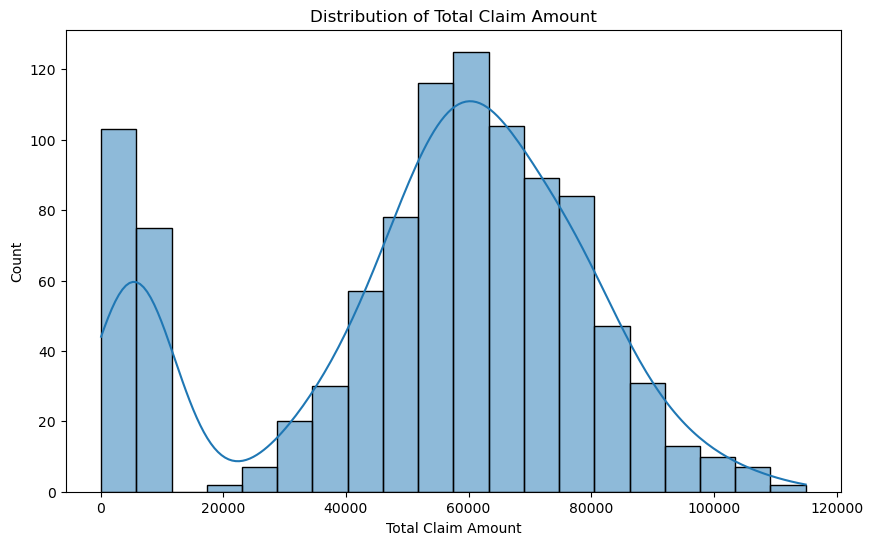

<Figure size 640x480 with 0 Axes>

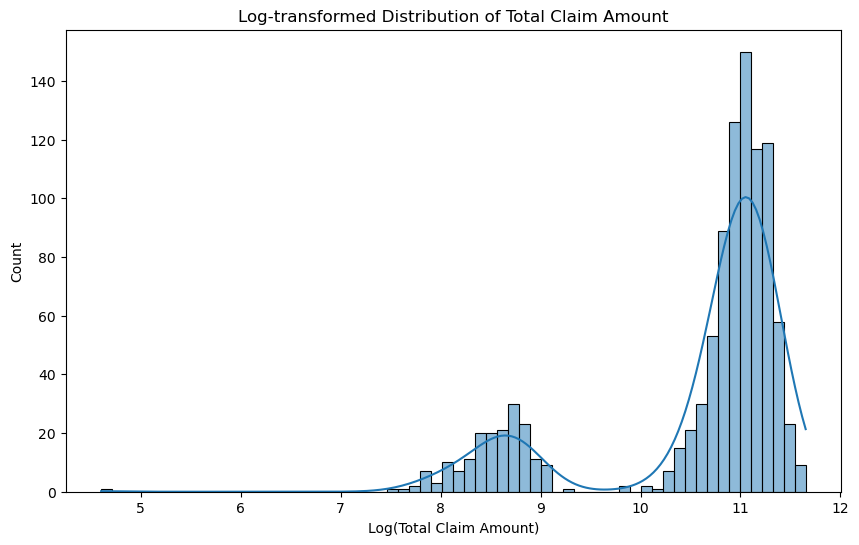

<Figure size 640x480 with 0 Axes>

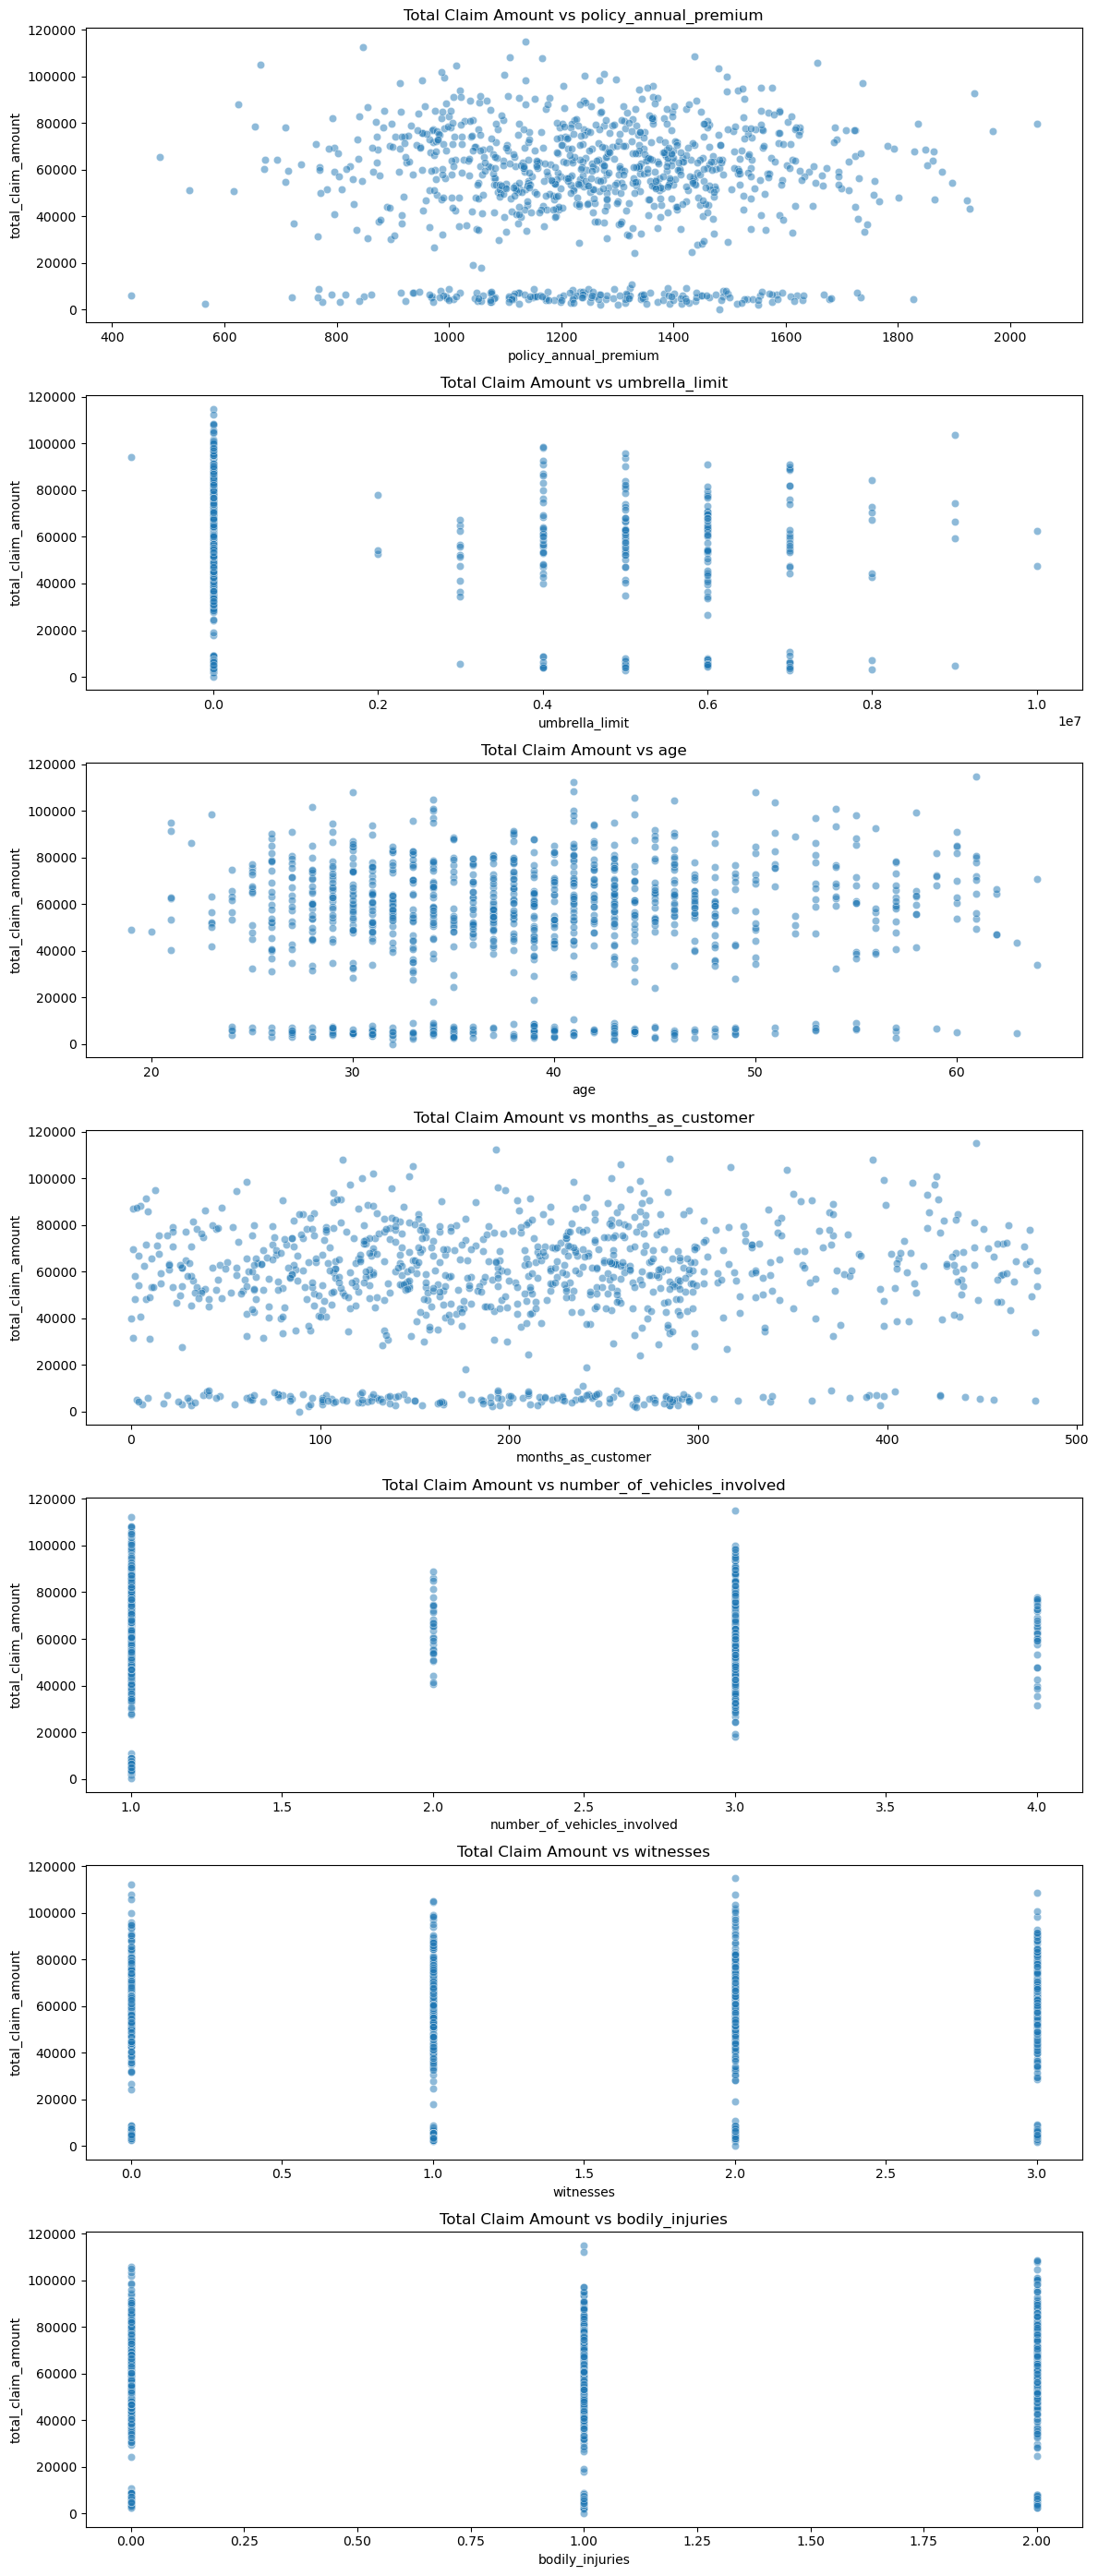

<Figure size 640x480 with 0 Axes>

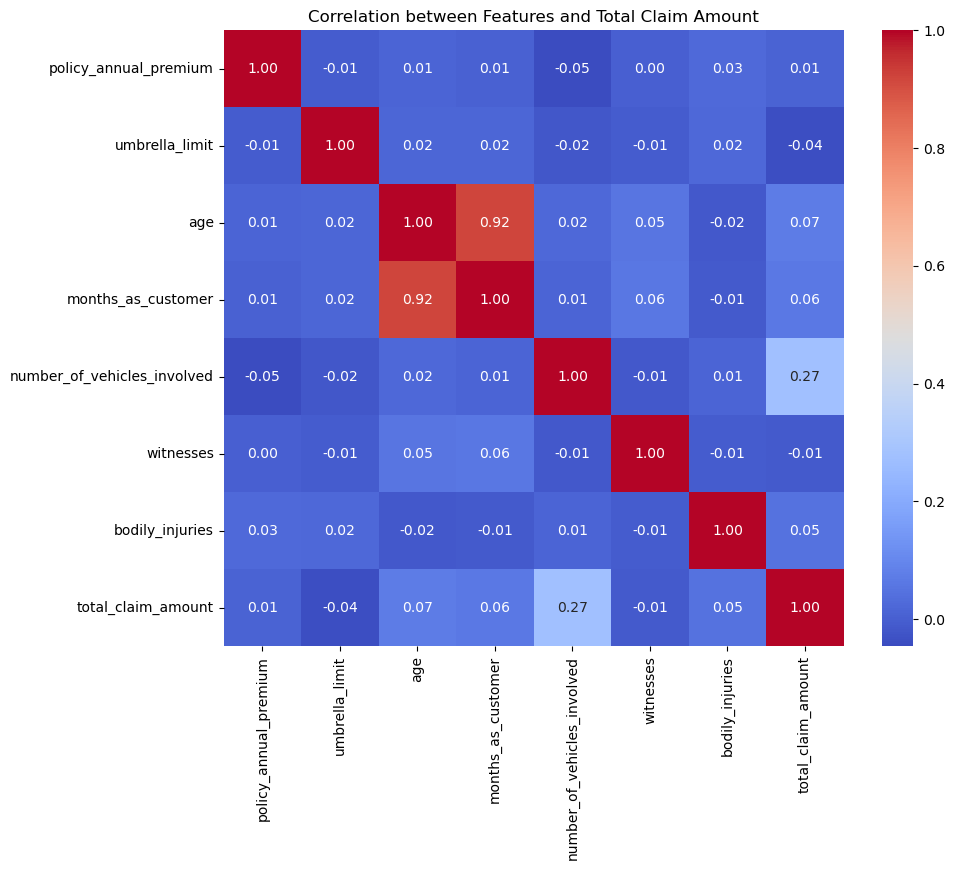

<Figure size 640x480 with 0 Axes>

In [21]:
#Data Preparation
#Remove zeros or very small values for claim amounts
df_model = df[df['total_claim_amount'] > 0].copy()

#Numerical features that might influence claim severity
features = ['policy_annual_premium', 'umbrella_limit', 'age', 'months_as_customer',
             'number_of_vehicles_involved', 'witnesses', 'bodily_injuries']

#Plot the distribution of total claim amount
plt.figure(figsize=(10, 6))
sns.histplot(df_model['total_claim_amount'], kde=True)  # Uses df_model
plt.title('Distribution of Total Claim Amount')
plt.xlabel('Total Claim Amount')
plt.show()
plt.savefig("../plots/distribution_of_total_claim_amount.png")

#Log-transformed distribution (better for skewed claim data)
plt.figure(figsize=(10, 6))
sns.histplot(np.log(df_model['total_claim_amount']), kde=True)  
plt.title('Log-transformed Distribution of Total Claim Amount')
plt.xlabel('Log(Total Claim Amount)')
plt.show()
plt.savefig("../plots/log-transformed_distribution_of_total_claim_amount.png")

#Relationship between features and total claim amount
fig, axes = plt.subplots(len(features), 1, figsize=(12, 4*len(features)))
for i, feature in enumerate(features):
    sns.scatterplot(x=df_model[feature], y=df_model['total_claim_amount'], alpha=0.5, ax=axes[i]) 
    axes[i].set_title(f'Total Claim Amount vs {feature}')
plt.tight_layout()
plt.show()
plt.savefig("../plots/total_claim_vs_feature.png")

#Correlation heatmap for numeric features
plt.figure(figsize=(10, 8))
corr_features = features + ['total_claim_amount']
corr_matrix = df_model[corr_features].corr()  
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Features and Total Claim Amount')
plt.show()
plt.savefig("../plots/correlation_between_features_and_claim_amount.png")


In [27]:
# Define target and predictors
y = df_model['total_claim_amount']

features = ['policy_annual_premium', 'umbrella_limit', 'age', 'months_as_customer',
             'number_of_vehicles_involved', 'witnesses', 'bodily_injuries']
x = df_model[features]

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Add constant to x for intercept
x_train_sm = sm.add_constant(x_train)  
x_test_sm = sm.add_constant(x_test)

#Log-transformed data
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

In [29]:
# --- Gamma Regression ---
gamma_model = sm.GLM(y_train, x_train_sm, family=Gamma(link=log()))
gamma_results = gamma_model.fit()
gamma_pred = gamma_results.predict(x_test_sm)

gamma_metrics = {
    "MSE": np.mean((y_test - gamma_pred) ** 2),
    "MAE": np.mean(np.abs(y_test - gamma_pred)),
    "RMSE": np.sqrt(np.mean((y_test - gamma_pred) ** 2)),
    "AIC": gamma_results.aic
}
pd.DataFrame([gamma_metrics]).to_csv("../data/gamma_metrics.csv", index=False)

print("\nGamma Regression Summary:")
print(gamma_results.summary())

print("\nGamma Regression Metrics:")
print(pd.DataFrame([gamma_metrics]).to_string(index=False))

# --- Lognormal Regression ---
lognormal_model = sm.OLS(log_y_train, x_train_sm)
lognormal_results = lognormal_model.fit()
lognormal_pred = np.exp(lognormal_results.predict(x_test_sm))  # back-transform

lognormal_metrics = {
    "MSE": np.mean((y_test - lognormal_pred) ** 2),
    "MAE": np.mean(np.abs(y_test - lognormal_pred)),
    "RMSE": np.sqrt(np.mean((y_test - lognormal_pred) ** 2)),
    "AIC": lognormal_results.aic
}
pd.DataFrame([lognormal_metrics]).to_csv("../data/lognormal_metrics.csv", index=False)

print("\nLognormal Regression Summary:")
print(lognormal_results.summary())

print("\nLognormal Regression Metrics:")
print(pd.DataFrame([lognormal_metrics]).to_string(index=False))

# --- Compare AIC values ---
gamma_aic = gamma_results.aic
lognormal_aic = lognormal_results.aic

if gamma_aic < lognormal_aic:
    print("Gamma model provides a better fit (lower AIC).")
elif lognormal_aic < gamma_aic:
    print("Lognormal model provides a better fit (lower AIC).")
else:
    print("Both models have the same AIC — no clear winner.")



Gamma Regression Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:     total_claim_amount   No. Observations:                  800
Model:                            GLM   Df Residuals:                      792
Model Family:                   Gamma   Df Model:                            7
Link Function:                    log   Scale:                         0.27388
Method:                          IRLS   Log-Likelihood:                -9548.2
Date:                Thu, 26 Feb 2026   Deviance:                       462.63
Time:                        11:57:20   Pearson chi2:                     217.
No. Iterations:                    12   Pseudo R-squ. (CS):            0.06273
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------

C:\Users\Trevor\Downloads\Anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


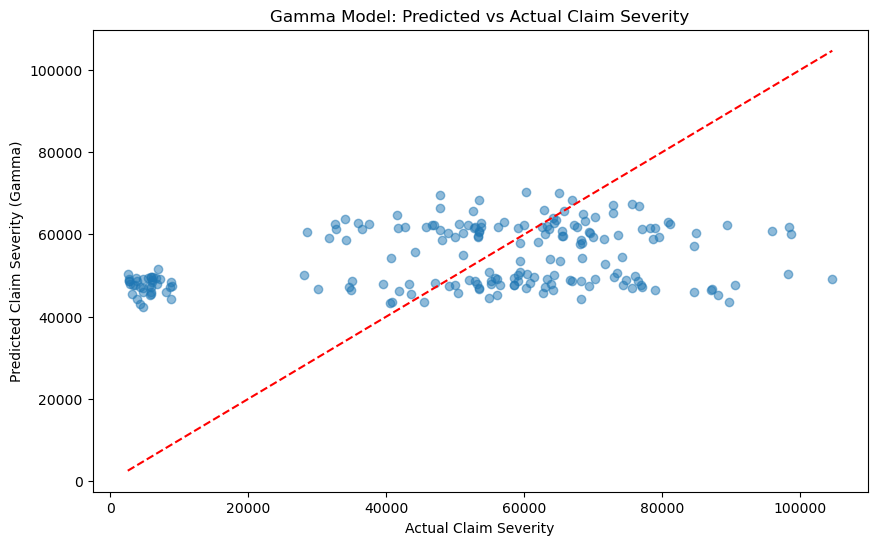

<Figure size 640x480 with 0 Axes>

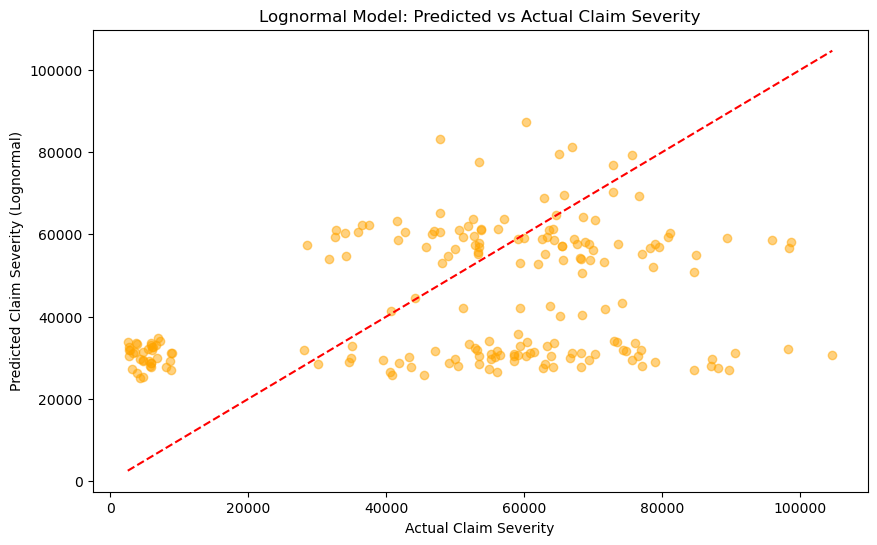

<Figure size 640x480 with 0 Axes>

In [17]:
#plot predicted vs actual severity
# Predictions from Gamma model
gamma_pred = gamma_results.predict(x_test_sm)

# Predictions from Lognormal model (remember we fit on log(y))
lognormal_pred_log = lognormal_results.predict(x_test_sm)
lognormal_pred = np.exp(lognormal_pred_log)  # back-transform to original scale

# Plot predicted vs actual for Gamma model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, gamma_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree line
plt.xlabel("Actual Claim Severity")
plt.ylabel("Predicted Claim Severity (Gamma)")
plt.title("Gamma Model: Predicted vs Actual Claim Severity")
plt.show()
plt.savefig("../plots/Gamma Model: Predicted vs Actual Claim Severity.png")

# Plot predicted vs actual for Lognormal model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lognormal_pred, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Claim Severity")
plt.ylabel("Predicted Claim Severity (Lognormal)")
plt.title("Lognormal Model: Predicted vs Actual Claim Severity")
plt.show()
plt.savefig("../plots/Lognormal Model: Predicted vs Actual Claim Severity.png")


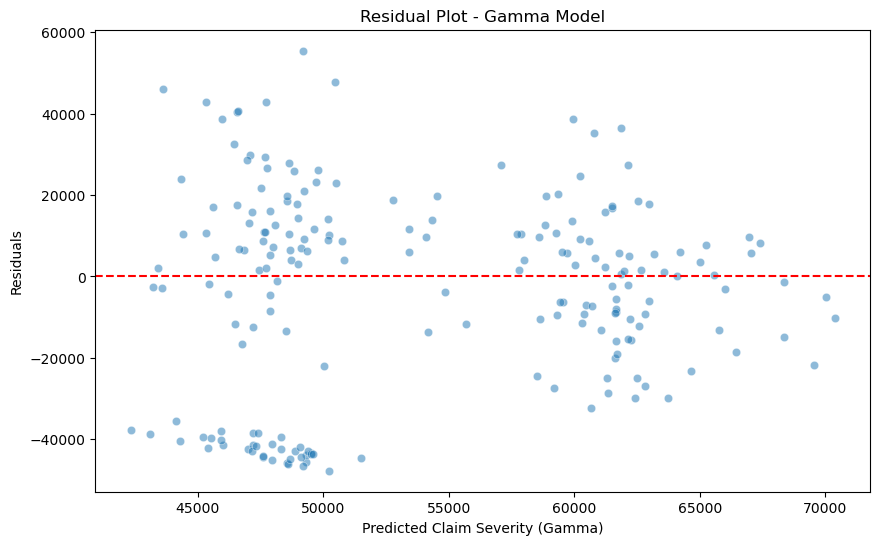

<Figure size 640x480 with 0 Axes>

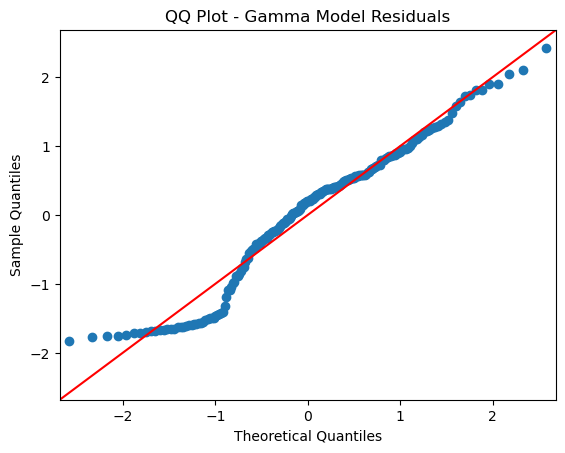

<Figure size 640x480 with 0 Axes>

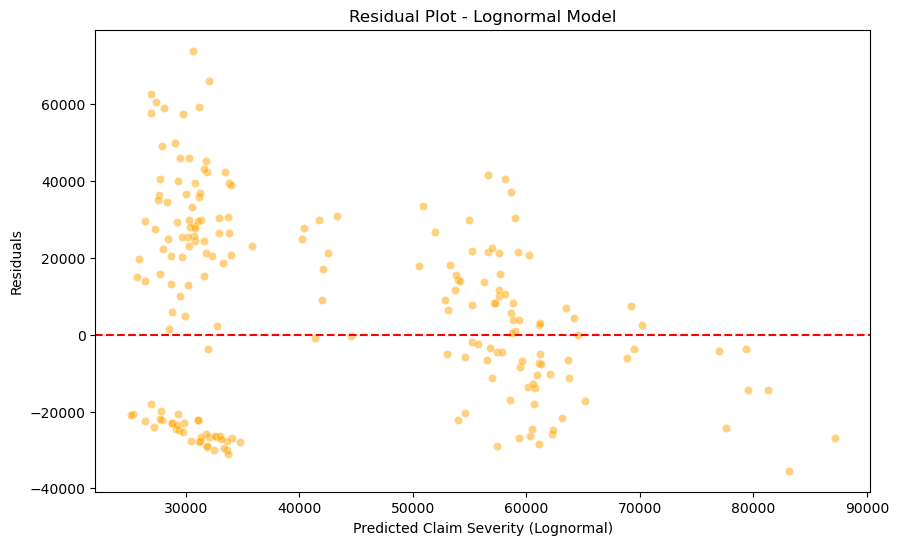

<Figure size 640x480 with 0 Axes>

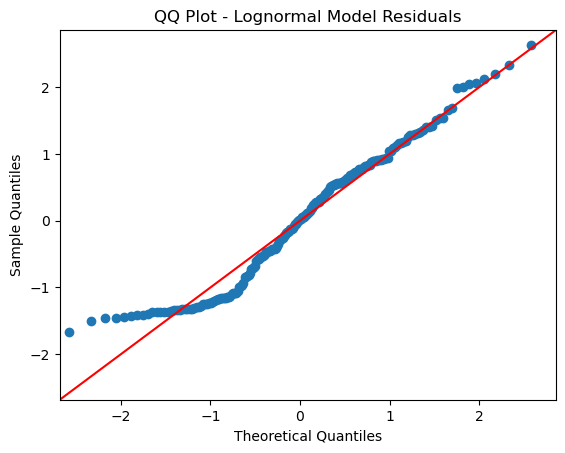

<Figure size 640x480 with 0 Axes>

In [8]:
#Residuals for Gamma model
gamma_pred = gamma_results.predict(x_test_sm)
gamma_resid = y_test - gamma_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=gamma_pred, y=gamma_resid, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Claim Severity (Gamma)")
plt.ylabel("Residuals")
plt.title("Residual Plot - Gamma Model")
plt.show()
plt.savefig("../plots/Residual Plot - Gamma Model.png")

#QQ plot for Gamma residuals
sm.qqplot(gamma_resid, line='45', fit=True)
plt.title("QQ Plot - Gamma Model Residuals")
plt.show()
plt.savefig("../plots/QQ Plot - Gamma Model Residuals.png")


#Residuals for Lognormal model
lognormal_pred_log = lognormal_results.predict(x_test_sm)
lognormal_pred = np.exp(lognormal_pred_log)  # back-transform
lognormal_resid = y_test - lognormal_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=lognormal_pred, y=lognormal_resid, alpha=0.5, color='orange')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Claim Severity (Lognormal)")
plt.ylabel("Residuals")
plt.title("Residual Plot - Lognormal Model")
plt.show()
plt.savefig("../plots/Residual Plot - Lognormal Model.png")

#QQ plot for Lognormal residuals
sm.qqplot(lognormal_resid, line='45', fit=True)
plt.title("QQ Plot - Lognormal Model Residuals")
plt.show()
plt.savefig("../plots/QQ Plot - Lognormal Model Residuals.png")


Generalized Pareto Parameters:
Shape (ξ): -0.8678531230316291
Location (μ): 97.27349641569259
Scale (σ): 87891.44210724375


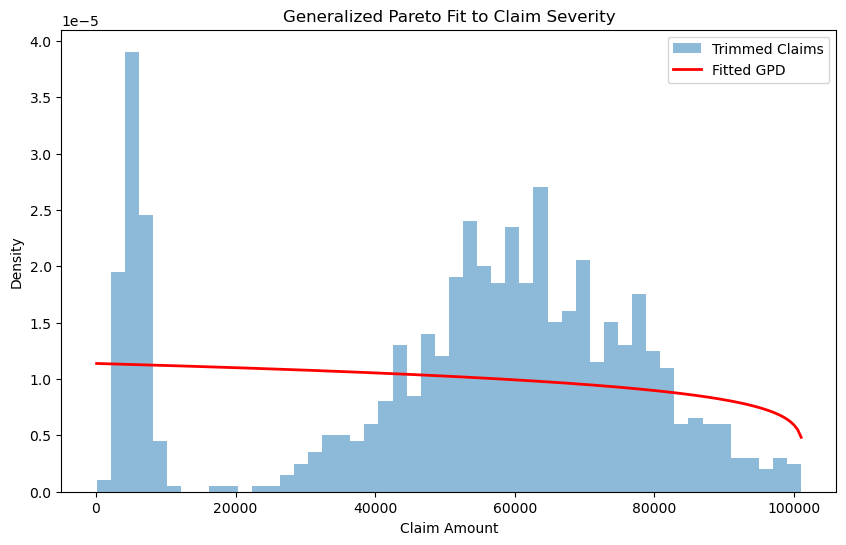

<Figure size 640x480 with 0 Axes>

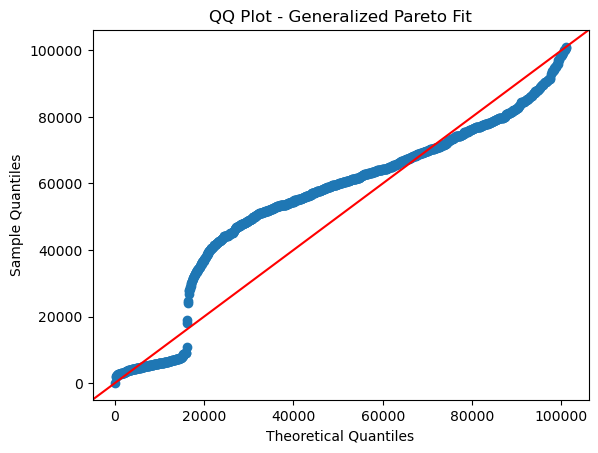

<Figure size 640x480 with 0 Axes>

In [32]:
from scipy.stats import genpareto

#Trim Outliers
# Define cutoff (e.g., 99th percentile)
cutoff = np.percentile(df_model['total_claim_amount'], 99)

# Trim dataset
df_trimmed = df_model[df_model['total_claim_amount'] <= cutoff].copy()

# Target variable
y_trimmed = df_trimmed['total_claim_amount']

# Fit Generalized Pareto Distribution(GPD)
shape, loc, scale = genpareto.fit(y_trimmed)
print("Generalized Pareto Parameters:")
print("Shape (ξ):", shape)
print("Location (μ):", loc)
print("Scale (σ):", scale)

# Diagnostic Plots

# Histogram with fitted PDF overlay
plt.figure(figsize=(10,6))
plt.hist(y_trimmed, bins=50, density=True, alpha=0.5, label="Trimmed Claims")

x_vals = np.linspace(y_trimmed.min(), y_trimmed.max(), 200)
plt.plot(x_vals, genpareto.pdf(x_vals, shape, loc=loc, scale=scale),
         'r-', lw=2, label="Fitted GPD")

plt.title("Generalized Pareto Fit to Claim Severity")
plt.xlabel("Claim Amount")
plt.ylabel("Density")
plt.legend()
plt.show()
plt.savefig("../plots/Generalized Pareto Fit to Claim Severity.png")

# QQ Plot 
sm.qqplot(y_trimmed, dist=genpareto, line='45',
          distargs=(shape,), loc=loc, scale=scale)
plt.title("QQ Plot - Generalized Pareto Fit")
plt.show()
plt.savefig("../plots/QQ Plot - Generalized Pareto Fit.png")



Lognormal Regression Summary (Bulk Claims):
                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     21.89
Date:                Thu, 26 Feb 2026   Prob (F-statistic):           1.65e-27
Time:                        12:04:38   Log-Likelihood:                -1280.2
No. Observations:                 950   AIC:                             2576.
Df Residuals:                     942   BIC:                             2615.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

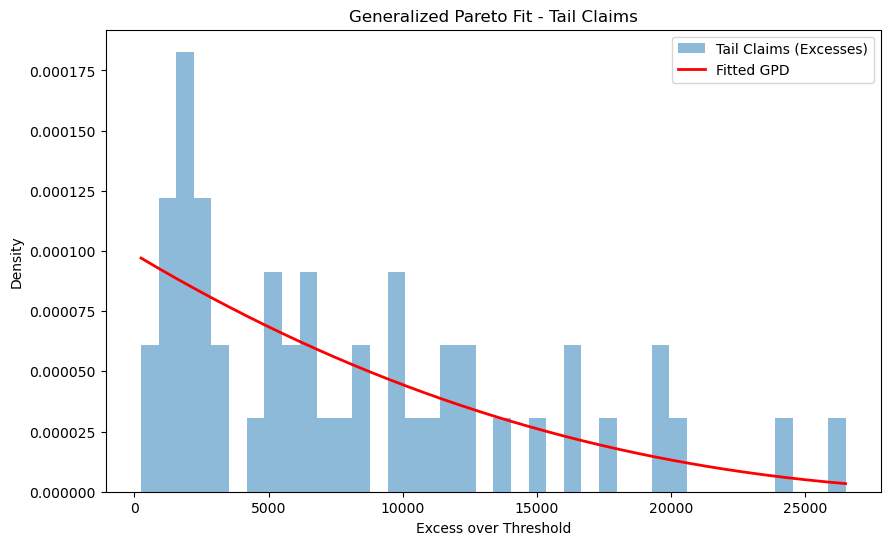

<Figure size 640x480 with 0 Axes>

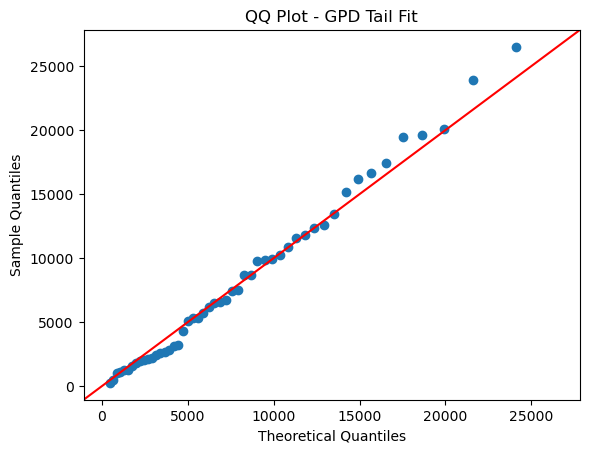

In [33]:
# Define threshold
threshold = np.percentile(df_model['total_claim_amount'], 95)  # 95th percentile

# Split dataset
df_bulk = df_model[df_model['total_claim_amount'] <= threshold].copy()
df_tail = df_model[df_model['total_claim_amount'] > threshold].copy()

# Fit Lognormal regression for bulk claims 
# Prepare train/test splits as before
X_bulk = df_bulk[features]
y_bulk = df_bulk['total_claim_amount']

# Fit OLS on log-transformed severity
lognormal_model = sm.OLS(np.log(y_bulk), sm.add_constant(X_bulk)).fit()
print("\nLognormal Regression Summary (Bulk Claims):")
print(lognormal_model.summary())

# Fit Generalized Pareto for tail claims
y_tail = df_tail['total_claim_amount'] - threshold  # excesses above threshold
shape, loc, scale = genpareto.fit(y_tail)
print("\nGeneralized Pareto Parameters (Tail Claims):")
print("Shape (ξ):", shape)
print("Location (μ):", loc)
print("Scale (σ):", scale)

# Diagnostics
# Histogram for tail claims with fitted GPD
plt.figure(figsize=(10,6))
plt.hist(y_tail, bins=40, density=True, alpha=0.5, label="Tail Claims (Excesses)")
x_vals = np.linspace(y_tail.min(), y_tail.max(), 200)
plt.plot(x_vals, genpareto.pdf(x_vals, shape, loc=loc, scale=scale),
         'r-', lw=2, label="Fitted GPD")
plt.title("Generalized Pareto Fit - Tail Claims")
plt.xlabel("Excess over Threshold")
plt.ylabel("Density")
plt.legend()
plt.show()
plt.savefig("../plots/Generalized Pareto Fit - Tail Claims.png")

# QQ plot for GPD fit
sm.qqplot(y_tail, dist=genpareto, line='45',
          distargs=(shape,), loc=loc, scale=scale)
plt.title("QQ Plot - GPD Tail Fit")
plt.show()


In [34]:
# --- GPD (Tail Modelling) ---
gpd_mean = threshold + genpareto.mean(shape, loc=loc, scale=scale)

gpd_pred = np.repeat(gpd_mean, len(y_test))

gpd_metrics = {
    "MSE": np.mean((y_test - gpd_pred) ** 2),
    "MAE": np.mean(np.abs(y_test - gpd_pred)),
    "RMSE": np.sqrt(np.mean((y_test - gpd_pred) ** 2))
    # AIC not available directly for GPD
}

pd.DataFrame([gpd_metrics]).to_csv("../data/gpd_metrics.csv", index=False)

print("\nGPD Model Metrics:")
print(pd.DataFrame([gpd_metrics]).to_string(index=False))




GPD Model Metrics:
         MSE          MAE         RMSE
2.773668e+09 46048.217962 52665.628617


In [15]:
# Combine predictions 
# Predict bulk claims using lognormal regression
bulk_pred = np.exp(lognormal_model.predict(sm.add_constant(X_bulk)))

# Predict tail claims using GPD (add back threshold)
tail_pred = threshold + genpareto.mean(shape, loc=loc, scale=scale)

# Combine into a single prediction series
df_bulk['predicted'] = bulk_pred
df_tail['predicted'] = tail_pred
df_combined = pd.concat([df_bulk, df_tail])

# ESSENTIALS FOR CHAPTER : 5
# Save hybrid severity predictions
os.makedirs("data", exist_ok=True)

df_combined[['total_claim_amount', 'predicted']].to_csv(
    "../data/severity_predictions.csv", index=False
)


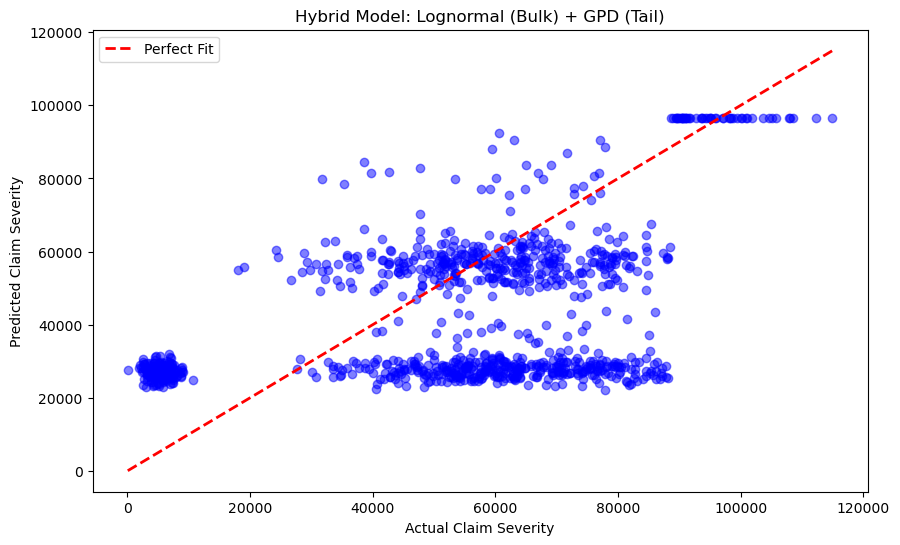

<Figure size 640x480 with 0 Axes>

In [12]:
# Diagnostics
# Predicted vs Actual plot
plt.figure(figsize=(10,6))
plt.scatter(df_combined['total_claim_amount'], df_combined['predicted'],
            alpha=0.5, color='blue')
plt.plot([df_combined['total_claim_amount'].min(), df_combined['total_claim_amount'].max()],
         [df_combined['total_claim_amount'].min(), df_combined['total_claim_amount'].max()],
         'r--', lw=2, label="Perfect Fit")
plt.xlabel("Actual Claim Severity")
plt.ylabel("Predicted Claim Severity")
plt.title("Hybrid Model: Lognormal (Bulk) + GPD (Tail)")
plt.legend()
plt.show()
plt.savefig("../plots/Hybrid Model: Lognormal (Bulk) + GPD (Tail).png")


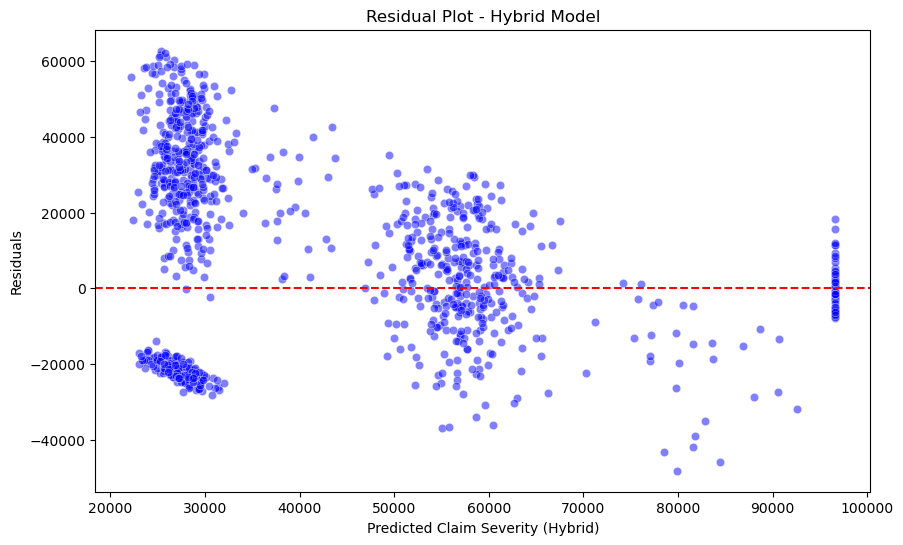

<Figure size 640x480 with 0 Axes>

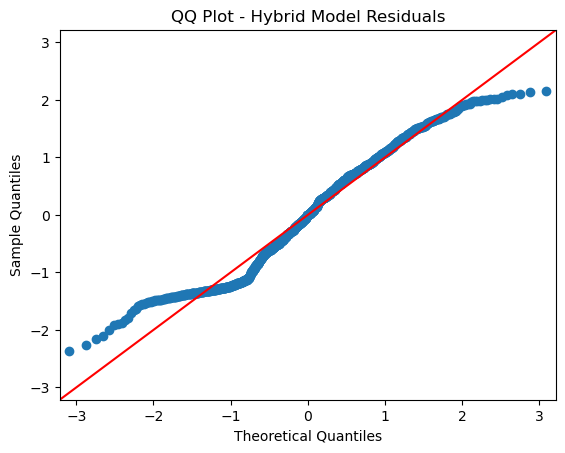

<Figure size 640x480 with 0 Axes>

In [13]:
# Residuals for hybrid model
df_combined['residuals'] = df_combined['total_claim_amount'] - df_combined['predicted']

# Residual plot
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_combined['predicted'], y=df_combined['residuals'], alpha=0.5, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Claim Severity (Hybrid)")
plt.ylabel("Residuals")
plt.title("Residual Plot - Hybrid Model")
plt.show()
plt.savefig("../plots/Residual Plot - Hybrid Model.png")

# QQ plot of residuals
sm.qqplot(df_combined['residuals'], line='45', fit=True)
plt.title("QQ Plot - Hybrid Model Residuals")
plt.show()
plt.savefig("../plots/QQ Plot - Hybrid Model Residuals.png")


In [16]:
# Function to calculate metrics
def calculate_sev_metrics(actual, predicted):
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(mse)
    return {'MSE': mse, 'MAE': mae, 'RMSE': rmse}

# Compute metrics using df_combined
hybrid_metrics = calculate_sev_metrics(df_combined['total_claim_amount'], df_combined['predicted'])

# ESSENTIALS FOR CHAPTER : 5
# Save metrics to data folder
pd.DataFrame([hybrid_metrics]).to_csv("../data/hybrid_metrics.csv", index=False)

# Print summary
print("Hybrid Severity Model Metrics:")
print(f"MSE: {hybrid_metrics['MSE']:.4f}, MAE: {hybrid_metrics['MAE']:.4f}, RMSE: {hybrid_metrics['RMSE']:.4f}")



Hybrid Severity Model Metrics:
MSE: 697936729.1600, MAE: 22146.2274, RMSE: 26418.4922
